# Gradient Random Forests

Recommended my Mike D.

This is another version of Random Forest, and this code is (initially) taken from the Antibiotics page.

Before we begin I asked chatGPT what we should alter between this and a random forest, to give us some insights!

**Short Answer:**  
While the scikit-learn `GradientBoostingClassifier` has defaults that can serve as a reasonable starting point, these defaults may not be ideal for a dataset with thousands of features. You’ll likely need to adjust the hyperparameters, possibly reduce dimensionality, or employ feature selection methods to optimize performance and training times.

**Detailed Explanation:**  
The scikit-learn implementation of `GradientBoostingClassifier` comes with the following common defaults (as of recent stable versions):

- **n_estimators=100:** Builds 100 trees sequentially.
- **learning_rate=0.1:** Each new tree contributes modestly to the ensemble.
- **max_depth=3:** Trees are fairly shallow (3 levels deep).
- **subsample=1.0:** By default, it uses all samples for every tree (no stochastic subsampling).
- **max_features=None:** Uses all features at every split by default.
- **min_samples_split=2 / min_samples_leaf=1:** Fairly lenient stopping criteria for splits, which could lead to overfitting in high-dimensional spaces.
- **no early stopping mechanism** by default.

For a dataset with 4,350 features (variables), some considerations include:

1. **High-Dimensional Feature Space:**  
   With thousands of features, you may find the default `max_depth` and `min_samples_split` parameters too permissive, potentially leading to overfitting. Trees might memorize noise rather than find generalizable patterns.

2. **Model Complexity and Overfitting:**  
   Shallow trees (max_depth=3) are usually good as a baseline, but the sheer number of features could still encourage complex behavior. Consider limiting the number of features each tree can see at once. For example, setting `max_features="sqrt"` or `max_features="log2"` can reduce complexity and might improve both performance and training time.

3. **Computation Time:**  
   With so many features, training could become slow, especially if you increase the number of estimators. Although 100 trees is often a reasonable start, you may want to experiment with fewer trees or add regularization and then incrementally increase the number of trees if performance improves.

4. **Regularization Parameters:**  
   Consider tweaking `min_samples_split` and `min_samples_leaf` to ensure that splits are made only when meaningful. Larger values for these parameters can help combat overfitting. Also, you could try a lower `learning_rate` combined with more trees to achieve smoother, more robust fits.

5. **Feature Selection or Dimensionality Reduction:**  
   If performance or training time is problematic, you might consider preprocessing steps:
   - Feature selection methods (e.g., variance thresholding, SelectKBest, or model-based selection)
   - Dimensionality reduction techniques (e.g., PCA)
   
   Reducing the feature space can lead to much more stable and faster training with default gradient boosting parameters.

**In Summary:**  
The defaults for `GradientBoostingClassifier` are a reasonable first attempt on small- to medium-dimensional datasets. With 4,350 features, it’s wise to either adjust the hyperparameters (especially `max_features`, `min_samples_leaf`, and `n_estimators`) or reduce the dimensionality of your data. Starting with defaults, you can iterate by tuning these parameters based on validation performance.

### Import data

In [1]:
import os
import sys

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
import json
import random

from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor, ClassifierChain
from sklearn.metrics import mean_squared_error

from scipy.stats import linregress

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor


# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

try:
  import google.colab
  IN_COLAB = True
  !pip install adjustText
  from google.colab import drive
  drive.mount('/content/drive')
  datadir = '/content/drive/MyDrive/Projects/CF/Adelaide/CF_Data_Analysis'
except ImportError:
  IN_COLAB = False
  datadir = '..'


from socket import gethostname
hostname = gethostname()
if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False

import cf_analysis_lib


### define the functions

We define:
 - **gb_classifer(X, y)**
 - **gb_regressor(X, y)**
 - **random_forest_regression(X, y)**
 - **random_forest_classifier(X, y)**
 - **plot_feature_importance**
 - **plot_feature_abundance**

In [3]:
n_estimators = 10000

def gb_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = GradientBoostingClassifier(
        max_features="sqrt", 
        n_estimators=n_estimators, 
        learning_rate=0.005, 
        min_samples_leaf=10,
        max_depth=5
    )

    """
    n_estimators=200,       # number of trees
    learning_rate=0.1,      # shrinkage
    max_depth=3,            # tree depth
    max_features='sqrt',    # random subset of features at each split
    min_samples_leaf=5,     # minimum samples per leaf
    random_state=42         # for reproducibility
    """
    
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)

    # Feature importance
    feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
    feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)
    return mse, feature_importances_sorted

def gb_regressor(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = GradientBoostingRegressor(max_features="sqrt", n_estimators=n_estimators)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)

    # Feature importance
    feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
    feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)
    return mse, feature_importances_sorted

def random_forest_regression(X, y):
  """
  Run a regressor for continuous data and return the mean squared error and the feature importances
  """

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Initialize and train a RandomForestRegressor model
  model = RandomForestRegressor(random_state=42, n_estimators=n_estimators) # You can adjust hyperparameters
  model.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = model.predict(X_test)

  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)

  # Feature importance
  feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
  feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)
  return mse, feature_importances_sorted

def random_forest_classifier(X, y):
  """
  Run a classifier for categorical data and return the mean squared error and the feature importances
  """

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Initialize and train a RandomForestRegressor model
  model = RandomForestClassifier(random_state=42, n_estimators=n_estimators) # You can adjust hyperparameters
  model.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = model.predict(X_test)

  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)

  # Feature importance
  feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
  feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)
  return mse, feature_importances_sorted


def plot_feature_importance(ax, feature_importances_sorted, title):

  # Create dotted lines and circles for each feature
  for feature in feature_importances_sorted.index[::-1]:
      importance = feature_importances_sorted.loc[feature, 'importance']
      ax.plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
      ax.plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

  ax.set_xlabel("Importance")
  ax.set_ylabel("")
  ax.set_title(title)

def plot_feature_abundance(ax, feature_df, intcol, title):
    """
    Plot the top n important features.

    use something like this:
    top20 = list(feature_importances_sorted[:20].index)+[intcol]
    plot_feature_abundance(ax, merged_df[top20], intcol, f"Plot of normalised measures that are important to distinguish '{intcol}' usage")
    """
    
    # before we plot the data we scale the data to make the mean 0 and the variance 1.
    # you can compare the values before and after by looking at merged_df[top20].max() and  scaled_df.max()
    #scaler = StandardScaler()
    scaler = MinMaxScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(feature_df), columns=feature_df.columns)
    scaled_df[intcol] = feature_df[intcol].values
    
    melted_df = pd.melt(scaled_df, id_vars=[intcol], var_name='Feature', value_name='Value')

    sns.boxplot(data=melted_df, x='Value', y='Feature', hue=intcol, fill=False, legend=False, color='k', fliersize=0, ax=ax)
    sns.stripplot(data=melted_df, x='Value', y='Feature', hue=intcol, jitter=True, alpha=0.5, dodge=True, ax=ax)

    ax.set_title(title)
    ax.set_xlabel('Normalised Abundance')
    ax.set_ylabel('')


### Read the data

In [4]:
sequence_type = "MGI"
datadir = '..'
#sslevel = 'level2_norm_ss.tsv.gz'
sslevel = 'subsystems_norm_ss.tsv.gz'
ss_df = cf_analysis_lib.read_subsystems(os.path.join(datadir, sequence_type, "FunctionalAnalysis", "subsystems", sslevel), sequence_type)
ss_df = ss_df.T
print(f"The subsystems df has shape: {ss_df.shape}")

taxa = "family"
genus_otu = cf_analysis_lib.read_taxonomy(datadir, sequence_type, taxa)
genus_otu = genus_otu.T
print(f"The taxonomy df has shape: {genus_otu.shape}")
metadata = cf_analysis_lib.read_metadata(datadir, sequence_type, categorise=True)
print(f"The metadata df has shape: {metadata.shape}")
df = ss_df.merge(genus_otu, left_index=True, right_index=True, how='inner')
print(df.shape)
df.head(5)

The subsystems df has shape: (127, 769)
The taxonomy df has shape: (127, 743)
The metadata df has shape: (127, 166)
(127, 1512)


,"2,3-diacetamido-2,3-dideoxy-d-mannuronic acid",2-O-alpha-mannosyl-D-glycerate utilization,2-aminophenol Metabolism,2-ketoacid oxidoreductases disambiguation,2-oxoglutarate dehydrogenase,2-phosphoglycolate salvage,3-amino-5-hydroxybenzoic Acid Synthesis,4-hydroxybenzoyl-CoA reductase,5-methylaminomethyl-2-thiouridine,A Hypothetical Protein Related to Proline Metabolism,...,Pelagicoccaceae,Puniceicoccaceae,Chthoniobacteraceae,Terrimicrobiaceae,Limisphaeraceae,Akkermansiaceae,Rubritaleaceae,Verrucomicrobia subdivision 6,Verrucomicrobiaceae,Eremiobacteraceae
1068841_20180306_S,10.085904,2784.895948,516.160945,231.778018,122.573392,342.327431,783.041862,0.0,4136.703664,827.439614,...,0.000000,0.808564,0.0,0.0,0.0,22.370261,0.808564,0.0,3.234255,0.0
1447437_20171212_S,59.260325,1065.438272,543.947408,554.136026,428.171446,301.915763,679.310468,0.0,3913.676651,732.956657,...,1.271183,0.635592,0.0,0.0,0.0,36.864321,0.000000,0.0,3.177959,0.0
1128691_20171206_S,0.000000,426.619709,912.767750,49.606943,213.640568,277.798880,423.312580,0.0,2093.412992,236.459761,...,0.000000,10.749798,0.0,0.0,0.0,14.333065,0.000000,0.0,10.749798,0.0
1128691_20171218_S,0.000000,659.087578,864.137047,139.140711,235.318676,355.174973,538.254855,0.0,2050.494687,341.749115,...,0.000000,0.000000,0.0,0.0,0.0,11.285217,0.000000,0.0,5.642608,0.0
1128691_20180116_S,14.478968,159.268644,593.637673,48.263225,358.354449,202.705547,348.701804,0.0,1570.967988,205.118708,...,0.000000,15.607929,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0


### Start with one example for antibiotic usage

Gradient boost regressor for 3 tobramycin_IV has error 0.16


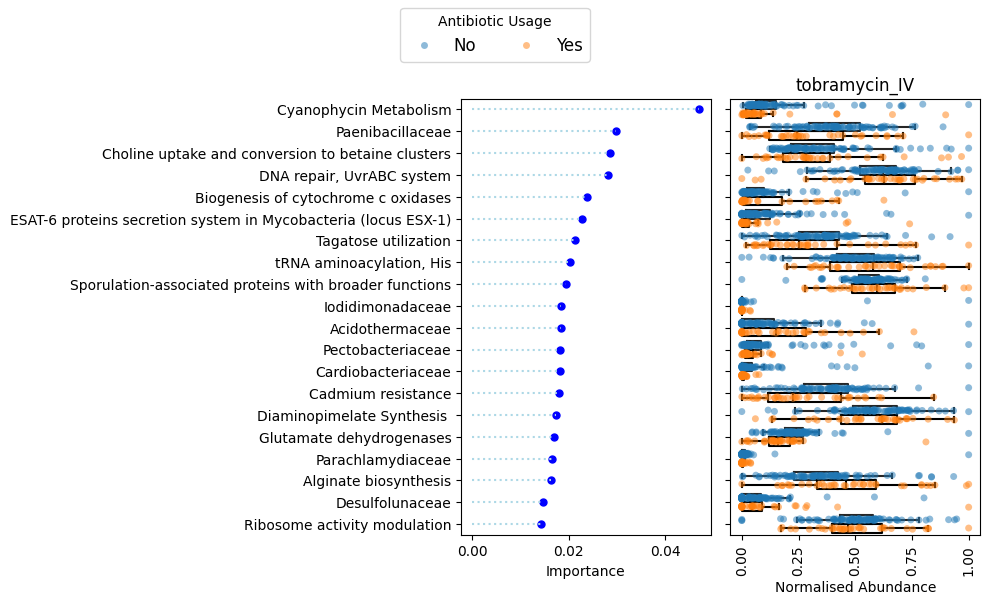

In [4]:
# this approach uses an inner join to ensure that we have the same 'interesting column' (intcol) 
# data in the same order as the data frame
intcol = '3 tobramycin_IV'
replace_index = re.compile(r'^\d+\s+')
intcol_title = replace_index.sub('', intcol)
merged_df = df.join(metadata[[intcol]])

# this data set models all bacteria
X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

if metadata[intcol].dtype == 'object':
  mse, feature_importances_sorted = gb_classifier(X, y)
  met = 'classifier'
else:
  mse, feature_importances_sorted = gb_regressor(X, y)
  met = 'regressor'


print(f"Gradient boost {met} for {intcol} has error {mse:.2f}")
n = 20
topN = list(feature_importances_sorted[:n].index)+[intcol]

fig, axes = plt.subplots(figsize=(10,6), nrows=1, ncols=2, sharey='row', sharex='col')
plot_feature_importance(axes[0], feature_importances_sorted[:n][::-1], "")
plot_feature_abundance(axes[1], merged_df[topN][::-1], intcol, intcol_title)

custom_labels = {0: 'No', 1: 'Yes'}
handles, labels = axes[1].get_legend_handles_labels()  # Get one set of handles and labels
updated_labels = [custom_labels[int(label)] for label in labels]

for ax in axes.flat:
    if ax.get_legend() is not None:  # Check if legend exists
        ax.get_legend().remove()

plt.xticks(rotation=90)
fig.legend(handles, updated_labels, loc='upper center', ncol=2, fontsize=12, title="Antibiotic Usage")
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

### Bugger!

Every time I run the GBC, I get a different top feature. Lets run it a bunch and see if the top five features ever repeat.

In addition, lets see if there is any correlation in those features as the model may just be picking a co-correlated feature

Cyanophycin Metabolism: 0.3200 (24 times)
Nitriliruptoraceae: 0.2880 (24 times)
Listeria Pathogenicity Island LIPI-1 extended: 0.2332 (24 times)
Pyruvate Alanine Serine Interconversions: 0.1886 (24 times)
Smithellaceae: 0.1876 (24 times)
Pseudoalteromonadaceae: 0.1667 (24 times)
Biogenesis of cytochrome c oxidases: 0.1647 (24 times)
One-carbon metabolism by tetrahydropterines: 0.1632 (24 times)
SecY2-SecA2 Specialized Transport System: 0.1415 (24 times)
Euzebyaceae: 0.1345 (24 times)


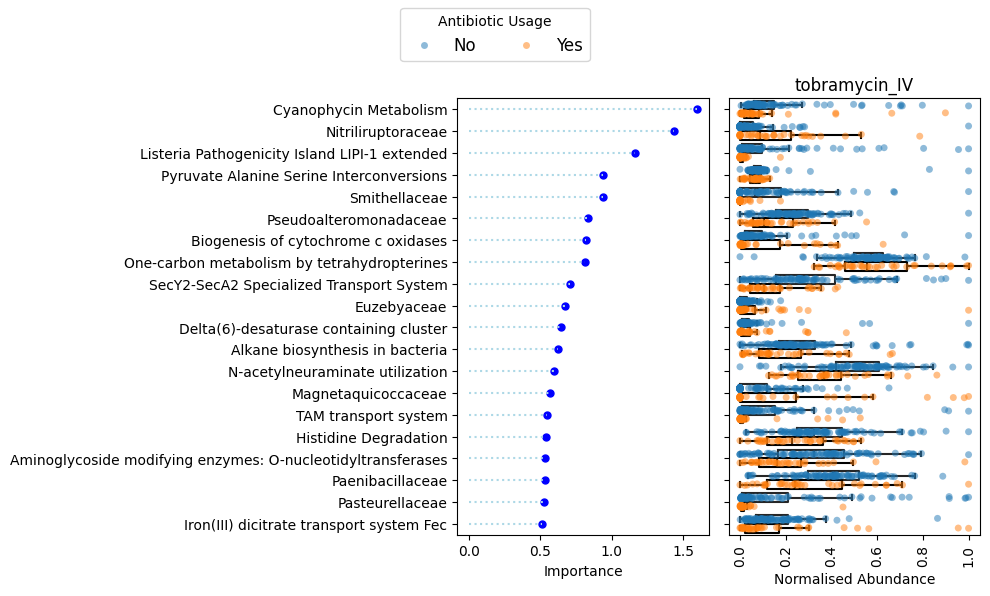

In [5]:

intcol = '3 tobramycin_IV'
replace_index = re.compile(r'^\d+\s+')
intcol_title = replace_index.sub('', intcol)
merged_df = df.join(metadata[[intcol]])

# this data set models all bacteria
X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

top_features = {}
top_feature_counts = {}
for i in range(100):
    if metadata[intcol].dtype == 'object':
      mse, feature_importances_sorted = gb_classifier(X, y)
      met = 'classifier'
    else:
      mse, feature_importances_sorted = gb_regressor(X, y)
      met = 'regressor'

    for f in feature_importances_sorted.index[:n]:
        top_features[f] = top_features.get(f, 0) + feature_importances_sorted.loc[f, 'importance']
        top_feature_counts[f] = top_feature_counts.get(f, 0) + 1

sorted_top_feats = sorted(top_features, key=lambda x: top_features[x], reverse=True)
for x in sorted_top_feats[:10]:
    print(f"{x}: {top_features[x]/5:.4f} ({top_feature_counts[f]} times)")

n = 20
tfdf = pd.DataFrame.from_dict(top_features, orient="index", columns=["importance"]).sort_values(by='importance', ascending=False)
topN = list(tfdf[:n].index)+[intcol]
fig, axes = plt.subplots(figsize=(10,6), nrows=1, ncols=2, sharey='row', sharex='col')
plot_feature_importance(axes[0], tfdf[:n][::-1], "")
plot_feature_abundance(axes[1], merged_df[topN][::-1], intcol, intcol_title)

custom_labels = {0: 'No', 1: 'Yes'}
handles, labels = axes[1].get_legend_handles_labels()  # Get one set of handles and labels
updated_labels = [custom_labels[int(label)] for label in labels]

for ax in axes.flat:
    if ax.get_legend() is not None:  # Check if legend exists
        ax.get_legend().remove()

plt.xticks(rotation=90)
fig.legend(handles, updated_labels, loc='upper center', ncol=2, fontsize=12, title="Antibiotic Usage")
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

## See the script

This is working very well, and the script (gradient_boosting.py)[../scripts/gradient_boosting.py) runs this code on all the predictors.

# Pseudomonas predictions

Re run the above analysis but predicting the Pseudomonas culture state.

In [27]:
metadata.columns[metadata.columns.str.contains('Pseudo')]

Index(['Pseudomonas Culture', 'CS_Pseudomonas aeruginosa',
       'CS_MDR_Pseudomonas aeruginosa', 'P12M_2_Pseudomonas aeruginosa',
       'N12M_Pseudomonas aeruginosa',
       'N12M_Pseudomonas aeruginosa (multi-resistant)',
       'O_Pseudomonas aeruginosa (multi-resistant)',
       'O_Pseudomonas aeruginosa (non-mucoid)',
       'O_Pseudomonas aeruginosa (mucoid)'],
      dtype='object')

Cholera toxin: 0.3582 (1 times)
Rhamnolipids in Pseudomonas: 0.2897 (1 times)
Quorum sensing regulation in Pseudomonas: 0.2095 (1 times)
Phenazine biosynthesis: 0.2022 (1 times)
Extracellular matrix proteins (PEL) involved in glucose-rich biofilm formation in Pseudomonas: 0.1904 (1 times)
Outer membrane porins in Pseudomonas and Acinetobacter: 0.1865 (1 times)
Siderophore Pyoverdine: 0.1818 (1 times)
Salmochelin-mediated Iron Acquisition: 0.1747 (1 times)
Iron siderophore sensor & receptor system: 0.1649 (1 times)
L-2-amino-4-methoxy-trans-3-butenoic acid synthesis: 0.1596 (1 times)


Couldn't use int for labels invalid literal for int() with base 10: '0.0'. Trying str


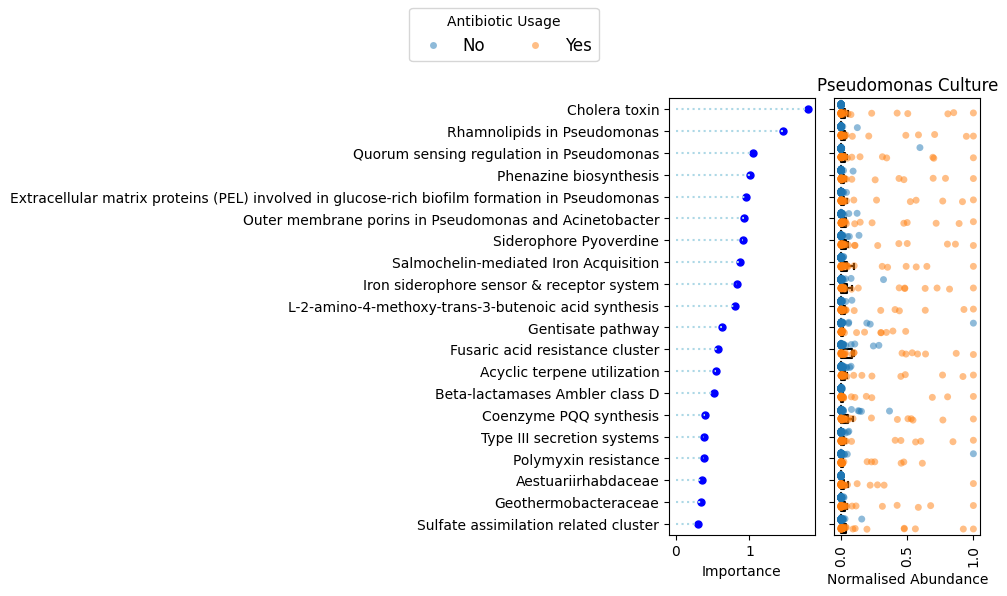

In [29]:
intcol = 'Pseudomonas Culture'
intcol_title = intcol
merged_df = df.join(metadata[[intcol]]).dropna(subset=intcol)

# this data set models all bacteria
X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

n=5
top_features = {}
top_feature_counts = {}
for i in range(100):
    if metadata[intcol].dtype == 'object':
      mse, feature_importances_sorted = gb_classifier(X, y)
      met = 'classifier'
    else:
      mse, feature_importances_sorted = gb_regressor(X, y)
      met = 'regressor'

    for f in feature_importances_sorted.index[:n]:
        top_features[f] = top_features.get(f, 0) + feature_importances_sorted.loc[f, 'importance']
        top_feature_counts[f] = top_feature_counts.get(f, 0) + 1

sorted_top_feats = sorted(top_features, key=lambda x: top_features[x], reverse=True)
for x in sorted_top_feats[:10]:
    print(f"{x}: {top_features[x]/5:.4f} ({top_feature_counts[f]} times)")

n = 20
tfdf = pd.DataFrame.from_dict(top_features, orient="index", columns=["importance"]).sort_values(by='importance', ascending=False)
topN = list(tfdf[:n].index)+[intcol]
fig, axes = plt.subplots(figsize=(10,6), nrows=1, ncols=2, sharey='row', sharex='col')
plot_feature_importance(axes[0], tfdf[:n][::-1], "")
plot_feature_abundance(axes[1], merged_df[topN][::-1], intcol, intcol_title)

custom_labels = {0: 'No', 1: 'Yes', '0.0': 'No', '1.0': 'Yes', '0': 'No', '1': 'Yes'}
handles, labels = axes[1].get_legend_handles_labels()  # Get one set of handles and labels
updated_labels = labels
try:
    updated_labels = [custom_labels[int(label)] for label in labels]
except ValueError as e:
    print(f"Couldn't use int for labels {e}. Trying str", file=sys.stderr)
    try:
        updated_labels = [custom_labels[str(label)] for label in labels]
    except ValueError as e:
        print(f"Couldn't use str for labels {e}. Labels: {lablels}", file=sys.stderr)
    
for ax in axes.flat:
    if ax.get_legend() is not None:  # Check if legend exists
        ax.get_legend().remove()

plt.xticks(rotation=90)
fig.legend(handles, updated_labels, loc='upper center', ncol=2, fontsize=12, title="Antibiotic Usage")
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

In [32]:
metadata[(metadata[intcol] < 1) & (metadata[intcol] > 0)][['pwCF_ID', intcol]]

,pwCF_ID,Pseudomonas Culture
NAME,,
770560_20181218_S,770560.0,0.288
676138_20180405_S,676138.0,0.288


In [25]:
type(merged_df.loc['634207_20180510_S', intcol])

numpy.float64

['No',
 'Yes',
 'Yes',
 'Yes',
 'Yes',
 'Yes',
 'No',
 'Yes',
 'Yes',
 'No',
 'Yes',
 'Yes',
 'No',
 'Yes',
 'Yes',
 'No',
 'Yes',
 'Yes',
 'Yes',
 'Yes',
 'No',
 'No',
 'Yes',
 'Yes',
 'Yes',
 'Yes',
 'No',
 'No',
 'No',
 'Yes',
 'No',
 'No',
 'Yes',
 'No',
 'Yes',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'Yes',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'Yes',
 'Yes',
 'No',
 'Yes',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'Yes',
 'No',
 'No',
 'No',
 'Yes',
 'No',
 'No',
 'No',
 'Yes',
 'Yes',
 'Yes',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'Yes',
 'No',
 'No',
 'Yes',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'Yes',
 'No',
 'No',
 'Yes',
 'Yes']

str

In [2]:
metadata = cf_analysis_lib.read_metadata(datadir, sequence_type, categorise=False)

NameError: name 'sequence_type' is not defined

In [13]:
metadata.loc['770560_20181218_S', 'Pseudomonas Culture']

nan

In [14]:
d.loc['770560_20181218_S', 'Pseudomonas Culture']

KeyError: '770560_20181218_S'

In [7]:
# For classification:
model = MultiOutputClassifier(GradientBoostingClassifier())

# For regression:
model = MultiOutputRegressor(GradientBoostingRegressor())

In [8]:
# Merge the dataframes
intcol = 'FEV1_best_FEV1' # interesting column!
merged_df = df.join(metadata[[intcol]].dropna(), how='inner')

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

if isinstance(metadata[intcol].dtype, pd.CategoricalDtype):
  mse, feature_importances_sorted = gb_classifier(X, y)
  met = 'classification'
else:
  mse, feature_importances_sorted = gb_regressor(X, y)
  met = 'regression'

print(f"Mean Squared Error for all columns: {mse}")

fig, axes = plt.subplots(figsize=(10,6), nrows=1, ncols=2)

plot_feature_importance(axes[0], feature_importances_sorted[:20], f"Top 20 features that predict {intcol}")




KeyError: "None of [Index(['FEV1_best_FEV1'], dtype='object')] are in the [columns]"

In [ ]:
df.shape